In [1]:
import numpy as np
import cv2
import time
import random
import matplotlib.pyplot as plt

In [2]:
def read_img(file):
    img_feat_list,label_list = [],[]
    with open(file) as f:
        for i in f:
            img_info = i.split(" ")
            img_name = img_info[0]
            img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(128,128))
            img = cv2.calcHist(img,[0],None,[64],[0,255])
            img_feat = img/255.0
            img_feat = img_feat.reshape(-1)
            img_feat_list.append(img_feat)
            
            label = int(img_info[-1])
            label_onehot = np.zeros(50)
            label_onehot[label] = 1
            label_list.append(label_onehot)
    return np.array(img_feat_list),np.array(label_list)

In [3]:
%%time
train_feat,train_label = read_img("train.txt")
val_feat,val_label = read_img("val.txt")
test_feat,test_label = read_img("test.txt")

CPU times: total: 39.9 s
Wall time: 39.9 s


In [4]:
class sigmoid():
    def __init__(self):
        pass
    def forward(self,x):
        self.x = x
        self.x1 = -self.x
        self.x2 = np.exp(self.x1)
        self.x3 = 1 + self.x2
        output = 1 / self.x3
        return output
    def backward(self,upg): # upg:upstream gradient
        self.gd3 = upg * (-1 / (self.x3)**2)
        self.gd2 = self.gd3 * 1
        self.gd1 = self.gd2 * np.exp(self.x1)
        self.gd0 = self.gd1 * -1
        return self.gd0
            
class relu():
    def __init__(self):
        pass
    def forward(self,x):
        self.x = x
        output = np.maximum(0,x)
        return output
    def backward(self,upgd):
        upgd[self.x <= 0] = 0
        return upgd
    
class softmax():
    def __init__(self):
        pass
    def forward(self,pred):
        self.x1 = np.exp(pred)
        output = self.x1/(self.x1.sum(axis=1)[:,None])
        # output = np.exp(pred)/sum(np.exp(pred))
        return output
    def backward(self,pred,gt_onehot):
        # n = diff.shape[0]
        # row_sum = diff.sum(axis=1)[:,None]
        # self.gd1 = np.zeros((n,n))
        # for i in range(n):
        #     for j in range(n):
        #         self.gd1[i,j] = self.x1[i,j] * (row_sum[i] - np.exp(diff[i,j])) / row_sum[i]
        # self.gd1 = diff * self.gd1
        # self.gd0 = self.gd1 * np.exp(self.x)
        return pred - gt_onehot

In [5]:
class crossentropy(): # softmax->neg log likelihood
    def __init__(self):
        self.softmax = softmax()
    def forward(self,pred,gt):
        pred = self.softmax.forward(pred)
        loss = self.negloglike(pred,gt)
        return loss

    def negloglike(self,pred,gt):
        # gt_onehot = self.onehot(gt)
        loss_matrix = np.sum(gt * np.log(pred),axis=1)
        loss_sum = round(-sum(loss_matrix),5)
        return loss_sum/len(pred)
    
    # def onehot(self,label_list):
    #     onehot = np.zeros((label_list.size,label_list.max()+1))
    #     onehot[np.arange(label_list.size),label_list] = 1
    #     return onehot

In [6]:
class linear():
    def __init__(self, in_dim, out_dim):
        self.weight = np.random.rand(in_dim,out_dim)
        self.bias = np.random.rand(out_dim)
    def forward(self, x):
        self.x = x
        output = np.dot(x,self.weight) + self.bias
        return output
    def backward(self,upgd,learning_rate): # get gradient and update weight
        d_out = np.dot(upgd,self.weight.T)
        d_weights = np.dot(self.x.T,upgd)
        d_bias = np.sum(upgd)
        
        self.weight -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias
        
        return d_out

In [7]:
class twolayerpercep():
    def __init__(self,in_dim,hidden_dim,out_dim):
        self.lin1 = linear(in_dim,hidden_dim)
        self.relu = relu()
        self.lin2 = linear(hidden_dim,out_dim)
        self.softmax = softmax()
    def forward(self,x):
        self.x1 = self.lin1.forward(x)
        self.a1 = self.relu.forward(self.x1)
        self.x2 = self.lin2.forward(self.a1)
        self.a2 = self.softmax.forward(self.x2)
        return self.a2
    def backward(self,pred,gt_onehot,learning_rate):
        d_softmax = self.softmax.backward(pred,gt_onehot)
        d_lin2 = self.lin2.backward(d_softmax,learning_rate)
        d_relu = self.relu.backward(d_lin2)
        d_lin1 = self.lin1.backward(d_relu,learning_rate)

In [8]:
# data loader
# class dataloader():
#     def __init__(self,data,label,size,shuffle,drop_last):
#         self.x = data
#         self.ind = np.arange(self.x.shape[0])
#         self.y = label
#         self.size = size
#         self.random = shuffle
#         if self.random:
#             random.shuffle(self.ind)
#         if drop_last:
#             self.max_batch = (len(self.ind)-len(self.ind)%32) / 32
#         else:
#             self.max_batch = len(self.ind) // len(self.ind)
#         self.batch = 0
#     def __iter__(self):
#         return self
#     def __next__(self):
#         if self.batch <= self.max_batch:
#             batch_ind = self.ind[self.batch*self.size : (self.batch+1)*self.size]
#             batch_img = self.x[batch_ind]
#             batch_label = self.y[batch_ind]
            
#         else:
#             self.num_batch = 0
#             if self.random:
#                 random.shuffle(self.ind)
#             raise StopIteration
        
#         return batch_img,batch_label
#             # generate x and y, size by batch_size
            

In [9]:
# train_loader = dataloader(train_feat,train_label,size=32,shuffle=True,drop_last=True)

In [10]:
def train(train_x,train_y,val_x,val_y,batch_size,epochs):
    model = twolayerpercep(in_dim=64,hidden_dim=50,out_dim=50)
    train_acc,train_acc_top5,train_loss = [],[],[]
    val_acc,val_acc_top5,val_loss = [],[],[]
    train_index = np.arange(train_x.shape[0])
    val_index = np.arange(val_x.shape[0])
    loss_fn = crossentropy()
    best_val_loss = 100
    for epoch in range(epochs):
        print("Epoch:{}".format(epoch+1))
        total_train_step = 0
        total_train_loss, total_train_acc, total_train_acc_top5 = 0,0,0
        random.shuffle(train_index)
        train_x = train_x[train_index]
        train_y = train_y[train_index]
        # random.shuffle(val_index)
        train_num_batch = len(train_index)//batch_size
        val_num_batch = len(val_index)//batch_size
        for i in range(train_num_batch):
            batch_img = train_x[i*batch_size : (i+1)*batch_size]
            batch_label = train_y[i*batch_size : (i+1)*batch_size,]
            output = model.forward(batch_img)
            # evaluate performance
            loss = loss_fn.forward(output,batch_label)
            total_train_loss += loss
            acc = (output.argmax(1) == batch_label.argmax(1)).sum()
            total_train_acc += acc
            label = batch_label.argmax(1)
            acc_top5 = len([j for j in range(len(label)) if label[j] in np.argsort(-output,axis=1)[j,:5]])
            total_train_acc_top5 += acc_top5
            model.backward(output,batch_label,learning_rate=0.001)
 
            total_train_step += 1
            if (total_train_step+1)%1000 == 0:
                print("Train step:{}, Train loss:{}".format(total_train_step+1,loss))
        train_acc.append(total_train_acc/len(train_y))
        train_acc_top5.append(total_train_acc_top5/len(train_y))
        train_loss.append(total_train_loss/train_num_batch)
        
        
        # Validation
        total_val_loss = 0
        total_val_acc = 0
        total_val_acc_top5 = 0
        for i in range(val_num_batch):
            val_batch_img = val_x[i*batch_size : (i+1)*batch_size]
            val_batch_label = val_y[i*batch_size : (i+1)*batch_size]
            output = model.forward(val_batch_img)
            loss = loss_fn.forward(output,val_batch_label)
            total_val_loss += loss
            acc = (output.argmax(1) == val_batch_label.argmax(1)).sum()
            total_val_acc += acc
            label = val_batch_label.argmax(1)
            acc_top5 = len([j for j in range(len(label)) if label[j] in np.argsort(-output,axis=1)[j,:5]])
            total_val_acc_top5 += acc_top5
        val_acc.append(total_val_acc/len(val_y))
        val_acc_top5.append(total_val_acc_top5/len(val_y))
        val_loss.append(total_val_loss/val_num_batch)
        
        if total_val_loss/val_num_batch < best_val_loss:
            best_val_loss = total_val_loss/val_num_batch
            # weight = model.state_dict()
            print("Validation loss:{}, Validation accuracy:{}".format(best_val_loss,total_val_acc/len(val_y)))
            # total_val_step += 1
        
        # torch.save(weight,"hw2_best_mod.pth")
        
    return train_acc, train_acc_top5, train_loss, val_acc, val_acc_top5, val_loss

In [11]:
%%time
training_result = train(train_feat,train_label,val_feat,val_label,batch_size=32,epochs=50)

Epoch:1
Train step:1000, Train loss:3.9122825
Validation loss:3.9119540625, Validation accuracy:0.02666666666666667
Epoch:2
Train step:1000, Train loss:3.9121690625
Validation loss:3.911917120535714, Validation accuracy:0.017777777777777778
Epoch:3
Train step:1000, Train loss:3.9122253125
Validation loss:3.911896562500001, Validation accuracy:0.02
Epoch:4
Train step:1000, Train loss:3.911466875
Validation loss:3.9118603348214287, Validation accuracy:0.02666666666666667
Epoch:5
Train step:1000, Train loss:3.91156375
Validation loss:3.911827232142857, Validation accuracy:0.017777777777777778
Epoch:6
Train step:1000, Train loss:3.9114184375
Validation loss:3.911786964285714, Validation accuracy:0.017777777777777778
Epoch:7
Train step:1000, Train loss:3.9112909375
Validation loss:3.9117440178571425, Validation accuracy:0.02
Epoch:8
Train step:1000, Train loss:3.9114815625
Validation loss:3.911693995535714, Validation accuracy:0.022222222222222223
Epoch:9
Train step:1000, Train loss:3.91159

In [16]:
# val acc top1
np.array(training_result[0]).mean(),np.array(training_result[3]).std()

(0.03345377023292539, 0.01011782438918419)

In [17]:
# val acc top5
np.array(training_result[1]).mean(),np.array(training_result[4]).std()

(0.14988645874457165, 0.021213785408503234)

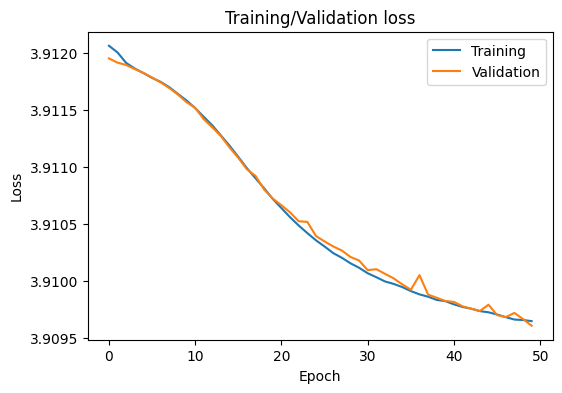

In [12]:
plt.figure(figsize=(6,4))
plt.plot(training_result[2],label="Training")
plt.plot(training_result[5],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training/Validation loss")
plt.legend()
plt.show()

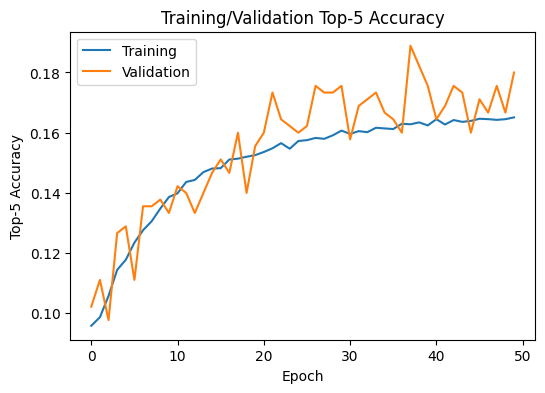

In [13]:
plt.figure(figsize=(6,4))
plt.plot(training_result[1],label="Training")
plt.plot(training_result[4],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Top-5 Accuracy")
plt.title("Training/Validation Top-5 Accuracy")
plt.legend()
plt.show()

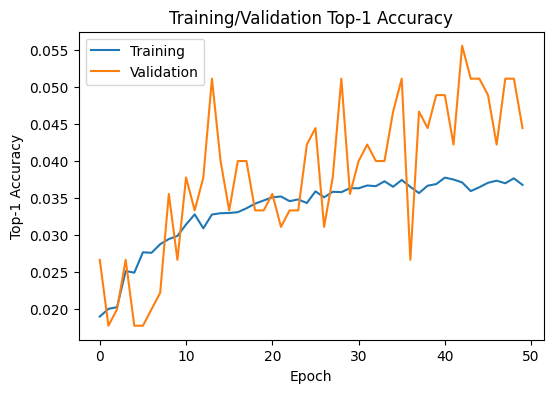

In [14]:
plt.figure(figsize=(6,4))
plt.plot(training_result[0],label="Training")
plt.plot(training_result[3],label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy")
plt.title("Training/Validation Top-1 Accuracy")
plt.legend()
plt.show()

In [15]:
model = twolayerpercep(in_dim=64,hidden_dim=64,out_dim=50)
total_test_acc = 0
total_test_acc_top5 = 0
test_index = np.arange(len(test_label))
test_num_batch = len(test_index)//32

for data in range(test_num_batch):
    test_batch_img = test_feat[data*32 : (data+1)*32]
    test_batch_label = test_label[data*32 : (data+1)*32]

    output = model.forward(test_batch_img)
    test_correct = (output.argmax(1) == test_batch_label.argmax(1)).sum()
    total_test_acc += test_correct
    label = test_batch_label.argmax(1)
    acc_top5 = len([i for i in range(len(label)) if label[i] in np.argsort(-output,axis=1)[i,:5]])
    total_test_acc_top5 += acc_top5
print("Test top1 accuracy:{}".format(total_test_acc/len(test_index)))
print("Test top5 accuracy:{}".format(total_test_acc_top5/len(test_index)))

Test top1 accuracy:0.015555555555555555
Test top5 accuracy:0.09777777777777778
